<a href="https://colab.research.google.com/github/elliot-d-kim/audience-segmentation/blob/main/audience_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audience Segmentation

## Set-up: Import + Config

Connect Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd

# Fuzzy matching
! pip install fuzzywuzzy python-Levenshtein
from fuzzywuzzy import process

# Unsupervised NLP (LDA)
import gensim
from gensim import corpora
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('stopwords')

# LDA performance eval
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 33.0 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Load data

Set file path according to location of CSV. Tip: Find the file using the left sidebar, click the three dots for more options, and copy the path.

In [ ]:
dataset_file_path = "/content/gdrive/MyDrive/COOP/Nancy's Pod/Capstone/PBL_DA_FA24_CAPSTONE_DATA.csv"

Detect CSV's encoding format using `chardet` library ... because this CSV has weird encoding

In [ ]:
import chardet

with open(dataset_file_path, 'rb') as f:
    chardet_result = chardet.detect(f.read())
print(chardet_result)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


Load the CSV.

In [ ]:
df = pd.read_csv(dataset_file_path, encoding=chardet_result['encoding'])
df.head()

,Audience Segment,Creative Size,Creative Messaging,Location,App/URL,Exchange,Device Make,Impressions,Clicks,Viewable Impressions,Measurable Impressions,Total Conversions,Gross Cost
0,Online Behavior>United States>Validated Demogr...,300x250,Subscribe Today - 10% Discount,"Los Angeles, California",abcnews.go.com,Google Ad Manager,Apple PC,10524,55.0,7601,10242,11.0,6136.133902
1,Online Behavior>United States>Finance Â» Finan...,320x50,Sign up Today - 10% Off,"Orlando-Daytona Beach, Florida",accuweather.com,PubMatic,Smartphone,18324,60.0,3145,13703,8.0,6996.231838
2,Online Behavior>United States>Hobbies and Leis...,300x250,Subscribe Today - 10% Discount,"San Francisco, California",accuweather.com,Google Ad Manager,Smartphone,7862,20.0,2152,6039,2.0,6506.433687
3,Online Behavior>United States>Intent Â» Auto B...,300x250,Sign up Now - 10% Off,"Grand Rapids-Kalamazoo, Michigan",accuweather.com,Xandr - Monetize SSP (AppNexus),Smartphone,10501,90.0,4126,7654,8.0,6244.517921
4,Online Behavior>United States>Beauty and Fitne...,300x250,Sign up Now - 10% Off,"Chicago, Illinois",accuweather.com,Magnite DV+,Apple PC,23156,73.0,4468,18821,15.0,6173.412890


Inspect `Audience Segment` column more closely. Notice formatting issues (e.g., Â» instead of >).

In [ ]:
df["Audience Segment"].head()

,Audience Segment
0,Online Behavior>United States>Validated Demogr...
1,Online Behavior>United States>Finance Â» Finan...
2,Online Behavior>United States>Hobbies and Leis...
3,Online Behavior>United States>Intent Â» Auto B...
4,Online Behavior>United States>Beauty and Fitne...


## Data cleansing

### Remove null rows

In [ ]:
# Filter rows where "Audience Segment" is NaN
nan_rows = df[df['Audience Segment'].isna()]
nan_rows

,Audience Segment,Creative Size,Creative Messaging,Location,App/URL,Exchange,Device Make,Impressions,Clicks,Viewable Impressions,Measurable Impressions,Total Conversions,Gross Cost
727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Remove rows with NaN values in the "Audience Segment" column
df = df.dropna(subset=['Audience Segment'])

### Clean up delimiter (>)

In [ ]:
# Clean up the 'Â»' character (and standardize surrounding whitespace)
df['Audience Segment'] = df['Audience Segment'].str.replace('Â»', '>', regex=False)
df['Audience Segment'] = df['Audience Segment'].str.replace('»', '>', regex=False)
df['Audience Segment'] = df['Audience Segment'].str.replace(' > ', '>', regex=False)
df['Audience Segment'] = df['Audience Segment'].str.replace('>', ' > ', regex=False)
df['Audience Segment']

,Audience Segment
0,Online Behavior > United States > Validated De...
1,Online Behavior > United States > Finance > Fi...
2,Online Behavior > United States > Hobbies and ...
3,Online Behavior > United States > Intent > Aut...
4,Online Behavior > United States > Beauty and F...
...,...
722,US > Brand Propensities > Automotive > Ford Cr...
723,US Technology > Social Media > Likely Behavior...
724,US > B2B > B2B Decision Maker Responsibilities...
725,Transactional > Q3 Fashion Shoppers


### Create tokens

In [ ]:
# Example code for preprocessing
df['tokens'] = df['Audience Segment'].apply(lambda x: [token.strip() for token in x.split('>')])
df['tokens']

,tokens
0,"[Online Behavior, United States, Validated Dem..."
1,"[Online Behavior, United States, Finance, Fina..."
2,"[Online Behavior, United States, Hobbies and L..."
3,"[Online Behavior, United States, Intent, Auto ..."
4,"[Online Behavior, United States, Beauty and Fi..."
...,...
722,"[US, Brand Propensities, Automotive, Ford Cred..."
723,"[US Technology, Social Media, Likely Behavior,..."
724,"[US, B2B, B2B Decision Maker Responsibilities,..."
725,"[Transactional, Q3 Fashion Shoppers]"


#### Eliminate noisy tokens

In [ ]:
noise_tokens = ['United States', 'US', 'Online Behavior', 'Interest',
                'Propensity Models', 'Intent', 'validated', 'Reach', 'OnAudience',
                'ConneXions', 'Brands', 'The Changing Consumer', 'Lotame',
                'Mobile - US', 'Brand Propensities']

In [ ]:
# Remove noise tokens from each token list
df['tokens'] = df['tokens'].apply(lambda tokens: [token for token in tokens if token not in noise_tokens])

# Display filtered tokens to verify
df['tokens']

,tokens
0,"[Validated Demographic, Gender and Age Combine..."
1,"[Finance, Financial Planning and Management, R..."
2,"[Hobbies and Leisure, Outdoors, Equestrian]"
3,"[Auto Buyers, Car Make, Audi Q]"
4,"[Beauty and Fitness, Fitness, Fitness Instruct..."
...,...
722,"[Automotive, Ford Credit Buyer Propensity]"
723,"[US Technology, Social Media, Likely Behavior,..."
724,"[B2B, B2B Decision Maker Responsibilities, Rea..."
725,"[Transactional, Q3 Fashion Shoppers]"


### Eliminate fuzzy matches from Audience Segment

In [ ]:
# Define words/phrases to remove
to_remove = ['United', 'States', 'US', 'online', 'behavior', 'interest',
             'propensity', 'models', 'intent', 'validated', 'reach', 'OnAudience',
             'connexions', 'combined', 'brands', 'changing', 'Lotame']

In [ ]:
# Function to remove fuzzy matches
def remove_fuzzy_matches(text):
    for word in to_remove:
        # Get the best match for the word in the text)
        match = process.extractOne(word, text.split(), score_cutoff=80)  # Adjust score_cutoff as needed
        if match:
            text = text.replace(match[0], '')  # Remove the matched word
    return text.strip()

# Apply the fuzzy matching removal function
df['Audience Segment'] = df['Audience Segment'].apply(remove_fuzzy_matches)

# # Clean the "Audience Segment" column
# df['Audience Segment'] = df['Audience Segment'].str.replace('Â»', '>', regex=False)
# df['Audience Segment'] = df['Audience Segment'].str.replace('United States', '', regex=False, case=False)
# df['Audience Segment'] = df['Audience Segment'].str.replace('US', '', regex=False, case=False)
# df['Audience Segment'] = df['Audience Segment'].str.replace('online', '', regex=False, case=False)
# df['Audience Segment'] = df['Audience Segment'].str.replace('behavior', '', regex=False, case=False)
# df['Audience Segment'] = df['Audience Segment'].str.replace('interest', '', regex=False, case=False)
# df['Audience Segment'] = df['Audience Segment'].str.replace('propensities', '', regex=False, case=False)
# df['Audience Segment'] = df['Audience Segment'].str.replace('intent', '', regex=False, case=False)
# df['Audience Segment'] = df['Audience Segment'].str.replace('validated', '', regex=False, case=False)
# df['Audience Segment'] = df['Audience Segment'].str.replace('reach', '', regex=False, case=False)
# df['Audience Segment'] = df['Audience Segment'].str.replace('OnAudience', '', regex=False, case=False)

# # Remove extra whitespace
# df['Audience Segment'] = df['Audience Segment'].str.strip()

df['Audience Segment'].head()

,Audience Segment
0,Demographic > Gender Age 25 older
1,> Financial Planning Management>Retirement P...
2,Leisure>Outdoors > Equestrian
3,> Auto Buyers > Car Make>Audi Q
4,Fitness>Fitness > Fitness Instruction Persona...


In [ ]:
data = df['Audience Segment'].astype(str).tolist()  # Ensure it's converted to a list of strings

## NLP using LDA

In [ ]:
# Train LDA model

# Tokenization and stopword removal
stop_words = set(stopwords.words('english'))
data_tokenized = [[word for word in word_tokenize(doc.lower()) if word.isalpha() and word not in stop_words] for doc in data]

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(data_tokenized)
corpus = [dictionary.doc2bow(text) for text in data_tokenized]

# LDA Model
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    random_state=42,
    passes=20,
    iterations=200,
    alpha='auto',
    eta='auto'
)

# Display the topics
topics = lda_model.print_topics(num_words=5)
for idx, topic in topics:
    print(f"Topic {idx + 1}: {topic}")

# Compute Coherence Score using the 'C_v' measure
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_tokenized, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()
print(f'Coherence Score: {coherence_score}')


Topic 1: 0.080*"financial" + 0.062*"hobbies" + 0.042*"sports" + 0.031*"card" + 0.025*"credit"
Topic 2: 0.110*"auto" + 0.090*"buyers" + 0.057*"car" + 0.054*"make" + 0.024*"technology"
Topic 3: 0.112*"travel" + 0.057*"entertainment" + 0.031*"streaming" + 0.031*"events" + 0.027*"media"
Topic 4: 0.027*"health" + 0.025*"credit" + 0.019*"lending" + 0.018*"multibuyer" + 0.014*"mobile"
Topic 5: 0.086*"sports" + 0.063*"entertainment" + 0.063*"buyer" + 0.061*"propensities" + 0.056*"media"
Topic 6: 0.057*"sociodemographic" + 0.037*"insurance" + 0.037*"lifestage" + 0.033*"education" + 0.029*"household"
Topic 7: 0.092*"vehicles" + 0.073*"brs" + 0.053*"decision" + 0.050*"services" + 0.047*"maker"
Topic 8: 0.082*"fitness" + 0.074*"consumer" + 0.058*"shopping" + 0.028*"home" + 0.025*"entertainment"
Topic 9: 0.120*"demographic" + 0.106*"age" + 0.071*"gender" + 0.050*"home" + 0.036*"news"
Topic 10: 0.040*"fashion" + 0.036*"shoppers" + 0.033*"clothing" + 0.027*"style" + 0.023*"vehicle"
Coherence Score: 0

In [ ]:
# Display the data as clustered by LDA

# Assign each document (audience segment) to the topic with the highest probability
topic_assignments = []
for doc_id, doc_bow in enumerate(corpus):
    # Get the topic distribution for each document
    topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)

    # Find the topic with the highest probability
    topic_assignments.append(max(topic_distribution, key=lambda x: x[1])[0])

# Group the original audience segments by the assigned topic
grouped_by_topic = {i: [] for i in range(lda_model.num_topics)}
for doc_id, topic_id in enumerate(topic_assignments):
    grouped_by_topic[topic_id].append(data[doc_id])

# Display the data points (audience segments) assigned to each topic
for topic_id, audience_segments in grouped_by_topic.items():
    print(f"\nTopic {topic_id + 1}:")
    for segment in audience_segments:
        print(f"  - {segment}")



Topic 1:
  - > Financial Planning  Management>Retirement  Pension
  - Fancial > Likely Credit Card > Card  Own Name > Any major Credit/Debit Card (Fancial)
  - > Home  Garden  > Cooking > Food Enthusiasts
  - > Multibuyer  > Paid with Credit Card
  - >  >   > Hobbies   > Food  Drinks > Es  Fast Food Restaurants
  - Financial > Estimated Discretionary Spending (Financial) > Greater than $2,499
  - >  >   > Hobbies   > Photography
  - >  > Sociodemographic > Estimated Current Home Value > $160,000-$199,999
  - > Personal Finance >  Planning
  - Sports > Skiing  Snowboarding
  - Financial > Likely Attitude   > Bank Selection > Customer Service Very Important (Financial)
  - Destinations > Mountain  Ski Resorts
  - >  >   > Hobbies   > Food  Drinks > High-end Spirit Drinkers
  - > Financial Planning  Management>Asset  Portfolio Management
  - > Investing>Stocks  Bonds
  - Leisure>Outdoors > Hiking  Camping
  - > Financial   Credit
  - Financial > Estimated Discretionary Spending > Greater

## NLP using TF-IDF and K-Means Clustering

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Preprocess the data
df['cleaned'] = df['Audience Segment'].str.replace(r'\W', ' ').str.lower()

# Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['cleaned'])

# Clustering
kmeans = KMeans(n_clusters=15, random_state=42)  # Adjust number of clusters as needed
df['cluster'] = kmeans.fit_predict(X)

# Show data points assigned to each cluster
clustered_data = df.groupby('cluster')['Audience Segment'].apply(list).reset_index()

# Print the clustered data in a formatted way
for index, row in clustered_data.iterrows():
    print(f"Cluster {row['cluster'] + 1}:")  # Add 1 to cluster index for user-friendly display
    for item in row['Audience Segment']:
        print(f"- {item}")
    print()  # Blank line for separation


Cluster 1:
- Consumer>B2B Work from Home

Cluster 2:
- Demographic > Gender  Age  18-54
- Demographic > Gender  Age  25-44
- Demographic > Gender  Age  45-54
- Demographic > Age>25-44
- Demographic > Gender  Age  18-54
- Demographic > Gender  Age  35-44
- Demographic > Age>35-44
- Demographic > Gender  Age  25-34
- Demographic > Gender>Male
- Demographic > Age>25-34
- Demographic > Age>18-54
- Demographic > Gender  Age  18-44
- Demographic > Gender  Age  25-54
- Demographic > Gender  Age  18-34
- Demographic > Gender  Age  25-44
- Demographic > Gender  Age  18-44
- Demographic > Age>25-54
- Demographic > Age > Specialty Age Range > 21+
- Demographic > Gender>Female

Cluster 3:
- Fitness>Fitness > Fitness Instruction  Personal Training
- Fitness>Face  Body Care > Skin  Nail Care
- Fitness>Face  Body Care > Unwanted Body  Facial Hair Removal
- Fitness>Cosmetology  Beauty Professionals
- Fitness>Fitness > Yoga  Pilates
- Fitness>Body Art
- Fitness>Fashion  Style > Fashion Modeling
- Fitne

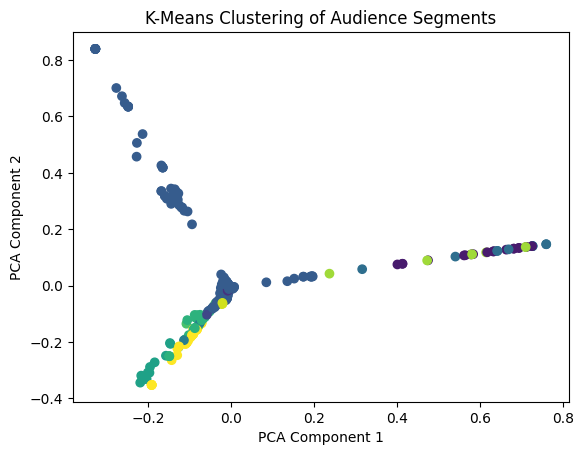

In [ ]:
# Optional: Dimensionality reduction for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X.toarray())

# Plot the clusters
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=df['cluster'])
plt.title('K-Means Clustering of Audience Segments')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

## DBSCAN

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import pandas as pd

# Load and preprocess data
df['cleaned'] = df['Audience Segment'].str.replace(r'\W', ' ').str.lower()

# Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['cleaned'])

# Dimensionality reduction
pca = PCA(n_components=50)  # Try reducing dimensions
X_reduced = pca.fit_transform(X.toarray())

# Density-based clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust parameters based on data
df['cluster'] = dbscan.fit_predict(X_reduced)

# Display clusters
clustered_data = df.groupby('cluster')['Audience Segment'].apply(list).reset_index()
for index, row in clustered_data.iterrows():
    print(f"Cluster {row['cluster'] + 1}:")
    for item in row['Audience Segment']:
        print(f"- {item}")
    print()


Cluster 0:
- Media  Entertainment > Gaming >  (Affinity) > Video Games
- Media  Entertainment > Audio  Video Streaming > Streaming Audio
- >  >   > Hobbies   > Pets > Cat Owners
- Media  Entertainment > Consumer Entertainment Technology
- > Shopping>Sports  Outdoors
- > Technology > Electronics & Gadgets
- > Shopping>Entertainment
- Fitness>Fashion  Style
- > Shopping>Home  Garden
- Entertainment>TV  Video
- >  >   > Hobbies   > Pets > Pet Enthusiast
- Media  Entertainment > Audio  Video Streaming > Streaming Video >  (Affinity)
- > Shopping>Fashion
- >  >   >  > Electronics  Gadgets
- >  > Pets
- Consumer>Streaming Services
- > Services>Restaurants
- >  >   >  > Pets
- Media  Entertainment > Audio  Video Streaming > Streaming Video
- > Services>Pets
- Media  Entertainment > Audio  Video Streaming > Streaming Video >  (Affinity) > Streaming Services
- >  Propensities > Restaurants and Dining > Seamless Buyer

Cluster 1:
- Demographic > Gender  Age  25  older
- > Financial Planning  Man

## Sentence-BERT

In [ ]:
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 5.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import numpy as np


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/23 [00:00<?, ?it/s]

Cluster 1:
- Fancial > Likely Credit Card > Card  Own Name > Any major Credit/Debit Card (Fancial)
- > Multibuyer  > Paid with Credit Card
- > Response Performance > Direct Marketing Responders
- Telecommunications (Telco)
- >Connected Impulse-Shopper
- Consumer>Internet
- > Shopping>Consumer Electronics > Computers, Laptops
- Purchase  > Q2 Environmentally Concerned Shoppers
- >Green Consumer
- Consumer>Direct to Consumer
- Consumer>Gaming Equipment
- Telecommunications (Telco) > Subscribers
- Mobile -  > Device Ownership > Smartphones > Huawei
- Telecom>Email  Messaging
- > Banking>Money Transfer  Wire Services
- > AUTO > Decision Maker for Auto Purchase >  shared equally  the decision
- Mobile -  > Device Ownership > Smartphones > ZTE
- Transactional > Q2 Graduation Gift Shoppers
- > Offline CPG Purchasers > Product Segment > Home Supplies
- Mobile -  > Demographics > Education > Lowest Education Achievement
- > Shopping>Consumer Electronics > Video Game Consoles
- Consumer>Active F

In [ ]:
# Load a pre-trained Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # 'all-MiniLM-L6-v2' is a lightweight model

# Generate sentence embeddings
embeddings = model.encode(df['Audience Segment'].tolist(), show_progress_bar=True)

In [ ]:
# Apply KMeans clustering
num_clusters = 10  # Adjust based on your data
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(embeddings)

# Display clusters in a formatted way
for cluster_num in range(num_clusters):
    print(f"Cluster {cluster_num + 1}:")
    cluster_items = df[df['cluster'] == cluster_num]['Audience Segment']
    for item in cluster_items:
        print(f"- {item}")
    print()  # Add a blank line for readability

Cluster 1:
- Fancial > Likely Credit Card > Card  Own Name > Any major Credit/Debit Card (Fancial)
- >  > Electronics > Video > Televisions
- >  > Software > Video Game Software
- > Response Performance > Direct Marketing Responders
- Telecommunications (Telco)
- >  > Science > Weather Forecast
- Consumer>Internet
- > Shopping>Consumer Electronics > Computers, Laptops
- >Green Consumer
- Consumer>Direct to Consumer
- Consumer>Gaming Equipment
- >  > Technology
- >   > Social > Premium User Generated Content
- Telecommunications (Telco) > Subscribers
- Mobile -  > Device Ownership > Smartphones > Huawei
- Telecom>Email  Messaging
- > Banking>Money Transfer  Wire Services
- Communities>File Sharing  Hosting
- Mobile -  > Device Ownership > Smartphones > ZTE
- Mobile -  > Demographics > Education > Lowest Education Achievement
- > Shopping>Consumer Electronics > Video Game Consoles
- Consumer>Active Facebook
- Mobile -  > Device Ownership > Smartphones > iOS (Apple) > iPhone X
- Mobile - 

## Hierarchical clustering

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
df['embeddings'] = df['Audience Segment'].apply(lambda x: model.encode(x))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

# Convert embeddings to an array
X = np.array(df['embeddings'].tolist())

# Initial clustering at a high level
agglom = AgglomerativeClustering(n_clusters=5)  # Top-level clusters
df['cluster'] = agglom.fit_predict(X)

# Optional: Sub-cluster large clusters if needed


In [ ]:
# Print clusters
for cluster_num in sorted(df['cluster'].unique()):
    print(f"Cluster {cluster_num + 1}:")
    cluster_items = df[df['cluster'] == cluster_num]['Audience Segment']
    for item in cluster_items:
        print(f"- {item}")
    print()


Cluster 1:
- Online Behavior > United States > Validated Demographic > Gender and Age Combined > Females 25 or older
- Online Behavior > United States > Finance > Financial Planning and Management > Retirement and Pension
- Online Behavior > United States > Hobbies and Leisure > Outdoors > Equestrian
- Online Behavior > United States > Beauty and Fitness > Fitness > Fitness Instruction and Personal Training
- Online Behavior > United States > Validated Demographic > Gender and Age Combined > Males 18-54
- Online Behavior > United States > Validated Demographic > Age > 55-64
- Online Behavior > United States > People and Society > Millennials
- Online Behavior > United States > Arts and Entertainment > Events and Listings > Bars, Clubs and Nightlife
- Online Behavior > United States > B2B > Occupation > Musician
- Online Behavior > United States > Sports > Sports League > NFL
- Online Behavior > United States > Sports > Team Sports > Basketball
- Online Behavior > United States > Beauty

## Reverse-weighted tokens

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Initialize Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

def get_weighted_embedding(text):
    # Tokenize by splitting on '>'
    tokens = [token.strip() for token in text.split('>') if token.strip()]
    n = len(tokens)  # Number of tokens

    # Generate embeddings and weights
    weighted_embeddings = []
    for i, token in enumerate(tokens):
        embedding = model.encode(token)

        # Calculate weight: proportional to position (closer to leaf = higher weight)
        weight = (i + 1) / n  # You can experiment with different weighting schemes here
        weighted_embeddings.append(embedding * weight)

    # Sum the weighted embeddings to get the final embedding
    final_embedding = np.sum(weighted_embeddings, axis=0)
    return final_embedding

# Apply the function to each category in your DataFrame
df['weighted_embeddings'] = df['Audience Segment'].apply(get_weighted_embedding)

# Convert list of embeddings to a 2D array
X = np.array(df['weighted_embeddings'].tolist())

# Perform clustering
from sklearn.cluster import KMeans
num_clusters = 10  # Adjust based on your data
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Display results by cluster
for cluster_num in sorted(df['cluster'].unique()):
    print(f"Cluster {cluster_num + 1}:")
    cluster_items = df[df['cluster'] == cluster_num]['Audience Segment']
    for item in cluster_items:
        print(f"- {item}")
    print()


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Cluster 1:
- US > B2B > B2B Decision Maker Responsibilities > Purchasing Utilities
- Real Estate > Occupancy > Owner Occupied
- Online Behavior > United States > People and Society > Millennials
- US > Reach > Sociodemographic > Dwelling Type > Multi-family Dwelling Unit
- Online Behavior > United States > B2B > Occupation > Musician
- US > Demographic > Family > Female Head of Household
- US > Reach > Sociodemographic > Dwelling Size > 1 Unit
- Online Behavior > United States > B2B > Occupation > MechanicalEngineer
- Online Behavior > United States > Law and Government > Public Safety
- Online Behavior > United States > Jobs and Education > Education
- Telecommunications (Telco)
- US > B2B > Purchase DM > Technology Services, Hardware and > or Software > I have no input into the final decision
- US > Reach > Sociodemographic > Estimated Current Home Value > $160,000-$199,999
- Online Behavior > United States > Life Event > Bride
- Online Behavior > United States > The Changing Consume

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# Initialize Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

def get_weighted_embedding(text):
    # Tokenize by splitting on '>'
    tokens = [token.strip() for token in text.split('>') if token.strip()]
    n = len(tokens)  # Number of tokens

    # Generate embeddings and weights
    weighted_embeddings = []
    for i, token in enumerate(tokens):
        embedding = model.encode(token)

        # Calculate weight: proportional to position (closer to leaf = higher weight)
        weight = (i + 1) / n  # You can experiment with different weighting schemes here
        weighted_embeddings.append(embedding * weight)

    # Sum the weighted embeddings to get the final embedding
    final_embedding = np.sum(weighted_embeddings, axis=0)
    return final_embedding

# Apply the function to each category in your DataFrame
df['weighted_embeddings'] = df['Audience Segment'].apply(get_weighted_embedding)

# Convert list of embeddings to a 2D array
X = np.array(df['weighted_embeddings'].tolist())

# Perform clustering
num_clusters = 10  # Adjust based on your data
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Find representative label for each cluster
def find_representative_label(cluster_df):
    # Calculate the centroid of the cluster
    cluster_center = np.mean(np.array(cluster_df['weighted_embeddings'].tolist()), axis=0)

    # Find the item closest to the cluster center
    similarities = cosine_similarity([cluster_center], np.array(cluster_df['weighted_embeddings'].tolist()))
    closest_idx = similarities.argmax()

    # Get the representative item as the label
    representative_label = cluster_df.iloc[closest_idx]['Audience Segment']
    return representative_label

# Apply the function to each cluster to get the representative label
cluster_labels = {}
for cluster_num in df['cluster'].unique():
    cluster_df = df[df['cluster'] == cluster_num]
    cluster_label = find_representative_label(cluster_df)
    cluster_labels[cluster_num] = cluster_label

# Add the cluster label to the DataFrame
df['cluster_label'] = df['cluster'].map(cluster_labels)

# Display results by cluster with labels
for cluster_num in sorted(df['cluster'].unique()):
    print(f"Cluster {cluster_num + 1}: ({df[df['cluster'] == cluster_num]['cluster_label'].iloc[0]})")
    cluster_items = df[df['cluster'] == cluster_num]['Audience Segment']
    for item in cluster_items:
        print(f"- {item}")
    print()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Cluster 1: (Online Behavior > United States > B2B > Occupation > Student)
- US > B2B > B2B Decision Maker Responsibilities > Purchasing Utilities
- Real Estate > Occupancy > Owner Occupied
- Online Behavior > United States > People and Society > Millennials
- US > Reach > Sociodemographic > Dwelling Type > Multi-family Dwelling Unit
- Online Behavior > United States > B2B > Occupation > Musician
- US > Demographic > Family > Female Head of Household
- US > Reach > Sociodemographic > Dwelling Size > 1 Unit
- Online Behavior > United States > B2B > Occupation > MechanicalEngineer
- Online Behavior > United States > Law and Government > Public Safety
- Online Behavior > United States > Jobs and Education > Education
- Telecommunications (Telco)
- US > B2B > Purchase DM > Technology Services, Hardware and > or Software > I have no input into the final decision
- US > Reach > Sociodemographic > Estimated Current Home Value > $160,000-$199,999
- Online Behavior > United States > Life Event >

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
import pandas as pd
from transformers import pipeline

# Initialize Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Define noise tokens
noise_tokens = [
    'United States', 'US', 'Online Behavior', 'Interest',
    'Propensity Models', 'Intent', 'validated', 'Reach', 'OnAudience',
    'ConneXions', 'Brands', 'The Changing Consumer', 'Lotame',
    'Mobile - US', 'Brand Propensities', 'Interest Propensities'
]

# Preprocess tokens by splitting and removing noise tokens
df['tokens'] = df['Audience Segment'].apply(lambda x: [token.strip() for token in x.split('>')])
df['tokens'] = df['tokens'].apply(lambda tokens: [token for token in tokens if token not in noise_tokens])

# Function to get weighted embedding
def get_weighted_embedding(tokens):
    n = len(tokens)
    weighted_embeddings = []

    # Check if there are tokens left after filtering
    if n == 0:
        return np.zeros(model.get_sentence_embedding_dimension())

    for i, token in enumerate(tokens):
        embedding = model.encode(token)
        weight = (i + 1) / n  # Weight inversely proportional to position (closer to leaf = higher weight)
        weighted_embeddings.append(embedding * weight)

    final_embedding = np.sum(weighted_embeddings, axis=0)
    return final_embedding

# Apply the function to the 'tokens' column
df['weighted_embeddings'] = df['tokens'].apply(get_weighted_embedding)

# Convert list of embeddings to a 2D array
X = np.array(df['weighted_embeddings'].tolist())

# Perform clustering
num_clusters = 8  # Adjust based on your data
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Function to generate a representative label from tokens
def generate_cluster_label(cluster_df):
    all_tokens = [token for tokens in cluster_df['tokens'] for token in tokens]
    token_counts = Counter(all_tokens)

    # Select the most common tokens as cluster labels
    common_tokens = token_counts.most_common(3)  # Top 3 tokens
    if common_tokens:
        # Join the top tokens to create a representative label
        return ", ".join(token for token, count in common_tokens)
    return "Other"

# Assign cluster labels using the derived tokens
df['cluster_label'] = df.groupby('cluster').apply(generate_cluster_label).reset_index(drop=True)

# Display results by cluster with labels
for cluster_num in sorted(df['cluster'].unique()):
    print(f"Cluster {cluster_num + 1}: ({df[df['cluster'] == cluster_num]['cluster_label'].iloc[0]})")
    cluster_items = df[df['cluster'] == cluster_num]['tokens']
    for item in cluster_items:
        print(f"- {item}")
    print()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
<ipython-input-55-8d96a3c228e9>:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['cluster_label'] = df.groupby('cluster').apply(generate_cluster_label).reset_index(drop=True)


Cluster 1: (Media and Entertainment, Arts and Entertainment, Hobbies and Interest)
- ['Finance', 'Financial Planning and Management', 'Retirement and Pension']
- ['Quick Service Restaurants']
- ['B2B', 'B2B Decision Maker Responsibilities', 'Purchasing Utilities']
- ['Real Estate', 'Occupancy', 'Owner Occupied']
- ['US Financial', 'Likely Credit Card', 'Card in Own Name', 'Any major Credit/Debit Card (Financial)']
- ['Sociodemographic', 'Dwelling Type', 'Multi-family Dwelling Unit']
- ['Auto Buyers', 'Type', 'Luxury']
- ['Media and Entertainment', 'wwe.com Buyer Propensity']
- ['B2B', 'B2B Decision Maker Responsibilities', 'Financial Services']
- ['Activities and Interests', 'Financial Aid']
- ['Shopping', 'Brand', 'Old Navy']
- ['Multibuyer Behaviors', 'Paid with Credit Card']
- ['Response Performance', 'Direct Marketing Responders']
- ['Finance', 'Insurance', 'Home Insurance']
- ['Sociodemographic', 'Dwelling Size', '1 Unit']
- ['B2B', 'Occupation', 'MechanicalEngineer']
- ['Finance'

## Label documents with pre-defined labels

In [ ]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import numpy as np

# Initialize model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Categories dictionary remains the same
categories = {
    "Sports": ["sports", "soccer", "tennis", "basketball", "fitness", "athlete", "game", "team", "player", "workout", "NFL", "UFC"],
    "Finance": ["finance", "investment", "retirement", "planning", "banking", "savings", "stocks", "trading", "budget", "wealth", "credit", "credit card" "mortgage", "insurance"],
    "Entertainment": ["entertainment", "movies", "tv", "music", "streaming", "shows", "film", "concert", "series", "media", "news", "local news", "politics"],
    "Automotive": ["automotive", "car", "vehicle", "buying", "dealer", "maintenance", "repair", "driving", "truck", "road", "motorcycle"],
    "Demographics": ["age", "age", "age", "gender", "demographics", "demo", "population", "segment", "group", "generation", "household", "income", "education", "sociodemographic"],
    "Outdoors": ["outdoors", "nature", "equestrian", "hiking", "camping", "adventure", "wildlife", "trail", "park", "wilderness"],
    "Travel": ["travel", "tourism", "vacation", "trip", "destination", "flight", "hotel", "resort", "cruise", "journey", "airlines"],
    "Food and Drink": ["food", "drink", "cuisine", "restaurant", "cooking", "recipe", "dining", "gourmet", "snack", "meal", "flavor", "nutrition"],
    "Style": ["fashion", "clothing", "accessories", "trends", "design", "outfit", "wardrobe", "couture", "runway", "beauty"],
    "Technology": ["technology", "gadgets", "software", "smartphone" "hardware", "innovation", "device", "digital", "electronics", "AI", "tech", "internet", "telecom", "mobile"],
    "Health": ["health", "wellness", "nutrition", "medical", "disease", "treatment", "exercise", "therapy", "prevention", "mental health", "fitness"],
    "Beauty": ["beauty", "cosmetics", "skincare", "makeup", "grooming", "aesthetics", "fragrance", "personal care", "salon"],
    "Home Goods": ["home", "furniture", "decor", "appliances", "bedding", "kitchenware", "interior", "garden", "accessories", "living space"],
    "Relationships": ["relationship", "dating", "marriage", "family", "friendship", "connection", "partnership", "community"],
    "Education": ["education", "learning", "school", "college", "university", "courses", "teaching", "training", "study", "knowledge"],
    "Pets": ["pets", "dogs", "cats", "animal", "care", "training", "grooming", "veterinary", "adoption", "pet supplies"],
    "Real Estate": ["real estate", "property", "housing", "homeownership", "rental", "mortgage", "realty", "land", "development"],
    "B2B": ["B2B", "business to business", "B2B decision maker", "enterprise", "commercial", "client relations"],
    "Life Events": ["life event", "new parent", "job search", "graduation", "movers", "retirement", "marriage", "divorce", "military"],
    "Public Services": ["law and government", "public safety", "military", "government", "legal", "insurance", "emergency services"]
}

def apply_position_weights(tokens, weight_factor):
    """Apply position-based weights to tokens, giving more weight to later tokens"""
    if isinstance(tokens, str):
        tokens = tokens.split()

    n = len(tokens)
    if n == 0:
        return ""

    # Calculate weights for each position
    # Later positions get higher weights
    weights = [1 + (i * weight_factor) for i in range(n)]

    # Repeat tokens based on their weights
    weighted_tokens = []
    for token, weight in zip(tokens, weights):
        # Round weight to nearest integer and repeat token that many times
        repeats = max(1, round(weight))
        weighted_tokens.extend([token] * repeats)

    return " ".join(weighted_tokens)

def calculate_category_embeddings(categories, weight_factor):
    """Calculate embeddings for each category by combining all keywords"""
    category_embeddings = {}
    for category, keywords in categories.items():
        # Apply position weights to keywords
        weighted_text = apply_position_weights(keywords, weight_factor)
        category_embeddings[category] = model.encode(weighted_text, convert_to_tensor=True)
    return category_embeddings

def assign_best_category(tokens, category_embeddings, threshold, weight_factor):
    """Assign category based on cosine similarity with threshold"""
    if not tokens:  # Handle empty tokens
        return "Other"

    # Apply position weights to input tokens
    if isinstance(tokens, list):
        weighted_text = apply_position_weights(tokens, weight_factor)
    else:
        weighted_text = apply_position_weights(str(tokens), weight_factor)

    # Generate document embedding
    doc_embedding = model.encode(weighted_text, convert_to_tensor=True)

    # Calculate similarities with all categories
    similarities = {}
    for category, cat_embedding in category_embeddings.items():
        similarity = util.pytorch_cos_sim(doc_embedding, cat_embedding).item()
        similarities[category] = similarity

    # Find best match
    best_category = max(similarities.items(), key=lambda x: x[1])

    # Return best category if above threshold, otherwise "Other"
    if best_category[1] >= threshold:
        return best_category[0]
    return "Other"

def classify_segments(df, min_threshold=0.3, weight_factor=0.1):
    """Main function to classify all segments in the dataframe"""
    # Calculate category embeddings once with weight factor
    category_embeddings = calculate_category_embeddings(categories, weight_factor)

    # Apply classification to each row with weight factor
    df['assigned_category'] = df['tokens'].apply(
        lambda x: assign_best_category(x, category_embeddings, min_threshold, weight_factor)
    )

    return df

def display_categories(df):
    # Calculate the percentage of labeled rows
    total_rows = len(df)
    labeled_rows = len(df[df['assigned_category'] != 'Other'])
    pct_labeled = (labeled_rows / total_rows) * 100 if total_rows > 0 else 0

    print(f"Labeled: {pct_labeled:.2f}%")

    # Group by assigned category and display segments
    grouped = df.groupby('assigned_category')
    for category, group in grouped:
        print(f"\n{category} ({len(group)} items):")
        for segment in group['Audience Segment']:
            print(f"- {segment}")

df = classify_segments(df, min_threshold=0.225, weight_factor=0.4)
display_categories(df)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Labeled: 95.60%

Automotive (90 items):
- Online Behavior > United States > Intent > Auto Buyers > Car Make > Audi Q
- Online Behavior > United States > Autos and Vehicles > Brands > Jeep
- Online Behavior > United States > Autos and Vehicles > Brands > Mercedes-Benz
- Online Behavior > United States > Intent > Auto Buyers > Type > Luxury
- Online Behavior > United States > Intent > Auto Buyers > Car Make > Volkswagen
- Online Behavior > United States > Autos and Vehicles > Brands > Dodge
- Online Behavior > United States > Autos and Vehicles > Brands > Ferrari
- US > AUTO > Primary Vehicle > New or Used > Pre-owned
- Online Behavior > United States > Autos and Vehicles > Brands > Rolls-Royce
- Online Behavior > United States > Intent > Auto Buyers > Car Make > Nissan
- OnAudience > Interest > Shopping > Shopping Mall Buyers
- Online Behavior > United States > Autos and Vehicles > Brands > Mazda
- Online Behavior > United States > Autos and Vehicles > Brands > Volvo
- Online Behavior >